In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import functional as F

import datetime

# 定义VAE模型
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(208, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 208),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def get_2D(self, x):
        mu, logvar = self.encode(x.view(-1, 208))
        z = self.reparameterize(mu, logvar)
        return z

    def decode(self, z):
        x = self.decoder(z)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 208))
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# 计算VAE的损失函数
def vae_loss(x, x_recon, mu, logvar, device, kl_weight, class_weight):
    weight = torch.ones_like(x).to(device)  # 创建与输入数据相同形状的权重向量，初始权重为1
    weight[:, -128:] = class_weight  # 将后面128维的权重设置为x
    loss_fn = nn.BCELoss(reduction='none')
    recon_loss = loss_fn(x_recon, x.view(-1, 208))   
    recon_loss = torch.sum(recon_loss * weight.view(-1, 208)) # 根据权重调整重构损失 并对损失求和
    kl_loss = -kl_weight * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# 官方的vae损失
def vae_loss_official(x, x_recon, mu, logvar, device, kl_weight, class_weight):
    weight = torch.ones_like(x).to(device)  # 创建与输入数据相同形状的权重向量，初始权重为1
    weight[:, -128:] = class_weight  # 将后面128维的权重设置为x
    recons_loss =F.mse_loss(x_recon, x * weight.view(-1, 208))
    kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
    loss = recons_loss + kl_weight * kl_loss
    return loss

# 自定义datasets
class Mydata_sets(Dataset):
    def __init__(self, path, device, transform=None):
        super(Mydata_sets, self).__init__()
        self.latent_z = torch.load(path, map_location=device)

    def __getitem__(self, index):
        z = self.latent_z[index].detach()
        return z

    def __len__(self):
        return len(self.latent_z)

# 设置训练参数
latent_dim = 2
batch_size = 32
epochs = 100
lr = 1e-3
kl_weight = 0.01
class_weight = 10.0
loss_function = "official"
device = torch.device("cuda:0")

# 加载数据集
train_dataset = Mydata_sets('./static/data/CIFAR10/latent_z/BigGAN_random_50k_png_208z_50000.pt', device = device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 初始化VAE模型和优化器
vae = VAE(latent_dim)
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# 训练VAE模型
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, x in enumerate(train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        x_recon, mu, logvar = vae(x)

        if loss_function == "official":
            loss = vae_loss_official(x, x_recon, mu, logvar, device, kl_weight, class_weight)
        else:
            loss = vae_loss(x, x_recon, mu, logvar, device, kl_weight, class_weight)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader.dataset)}")

# 关键参数信息
title = "epoch = " + str(epochs) + " kl = " + str(kl_weight) + " cl_w = " + str(class_weight) + " loss = " + str(total_loss / len(train_loader.dataset)) + " loss_fn="+loss_function 

time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
torch.save(vae.state_dict(), "./临时垃圾-随时可删/20230814vae训练/vae_state_dict_"+ title + " " + time + ".pt")



Epoch 1/100, Loss: 1.6543697480010986
Epoch 2/100, Loss: 1.6521416844177246
Epoch 3/100, Loss: 1.6508137592315675
Epoch 4/100, Loss: 1.6502345662689208
Epoch 5/100, Loss: 1.649937518081665
Epoch 6/100, Loss: 1.6496399923706055
Epoch 7/100, Loss: 1.6491923685455323
Epoch 8/100, Loss: 1.6491682342529297
Epoch 9/100, Loss: 1.649103684158325
Epoch 10/100, Loss: 1.6490042106628418
Epoch 11/100, Loss: 1.6489375231933594
Epoch 12/100, Loss: 1.648939007873535
Epoch 13/100, Loss: 1.6489667495727538
Epoch 14/100, Loss: 1.6489727814483643
Epoch 15/100, Loss: 1.6489591346740722
Epoch 16/100, Loss: 1.6489186030578613
Epoch 17/100, Loss: 1.6489482968139648
Epoch 18/100, Loss: 1.6489558071899415
Epoch 19/100, Loss: 1.6489516700744629
Epoch 20/100, Loss: 1.6489577370452881
Epoch 21/100, Loss: 1.648951711959839
Epoch 22/100, Loss: 1.6489492375183106
Epoch 23/100, Loss: 1.6489343563079835
Epoch 24/100, Loss: 1.6489157543945312
Epoch 25/100, Loss: 1.6489197924041747
Epoch 26/100, Loss: 1.6489866157531738

In [2]:
# 降维
vae.eval()
latent_z = torch.load("./static/data/CIFAR10/latent_z/BigGAN_random_50k_png_208z_50000.pt", map_location=device)
print(latent_z.shape)
mu, logvar = vae.encode(latent_z.view(-1, 208))
zs = vae.reparameterize(mu, logvar)
print(zs.shape)

torch.Size([50000, 208])
torch.Size([50000, 2])


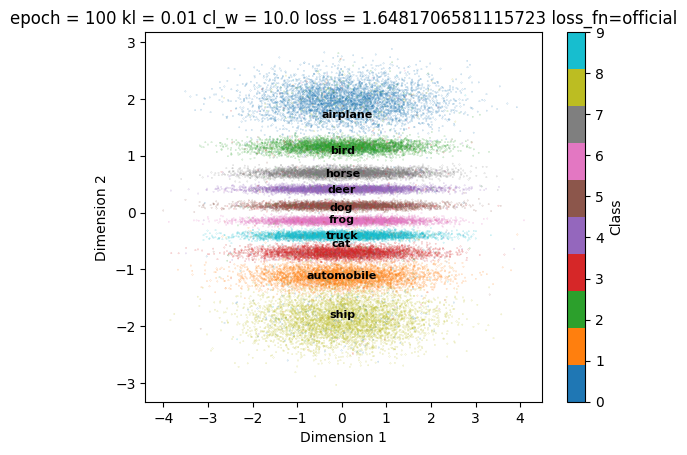

In [3]:
# 绘制散点图

import torch
import numpy as np
import matplotlib.pyplot as plt

labels = torch.load("./临时垃圾-随时可删/labels.pt")
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# 将张量转换为 NumPy 数组
zs_np = zs.to(torch.device("cpu")).detach().numpy()
# zs_np = zs_np[:5000]
# labels = labels[:5000]

# 获取类别数量和颜色映射
color_map = plt.get_cmap("tab10")

# 绘制散点图
plt.scatter(zs_np[:, 0], zs_np[:, 1], s=0.01, c=labels, cmap=color_map)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title(title)
plt.colorbar(label="Class")

# 添加类别标签
for i in range(10):
    label = cifar10_labels[i]
    x = zs_np[labels == i, 0].mean()
    y = zs_np[labels == i, 1].mean()
    plt.text(x, y, label, fontsize=8, ha='center', va='center', weight='bold')


plt.show()